In [26]:
#Importing necessary libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random
from sklearn.model_selection import train_test_split
np.random.seed(1337)


In [61]:
#Defining the Franke function given in the project text

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    
    return term1 + term2 + term3 + term4*0.02

In [62]:
#Code for setting up our design matrix

def create_x(x,y,n):
 
    L = len(x)
    X = np.ones((L, int((n + 1) * (n + 2) / 2)))

    for i in range(n + 1):
        t = int((i) * (i + 1) / 2)
        for j in range(i + 1):
            X[:, t + j] = x ** (i - j) * y ** j

    return X


#MSE, bias and variance functions from lecture notes week 37 
def mse_bootstrap(z_test, z_pred):
    mse = np.mean(np.mean((z_test - z_pred)**2, axis=1, keepdims=True))
    bias = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True))**2) 
    variance = np.mean((z_pred - np.mean(z_pred, axis=1, keepdims=True)))
    return mse, bias, variance

#bootstrap function as shown in lecture notes from week 37
def bootstrap(x_train, x_test, z_train, z_test, n_bootstrap, degree):
    
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression(fit_intercept=False))
    z_t = np.zeros((z_train.shape[0], n_bootstrap))
    z_pred = np.zeros((z_test.shape[0], n_bootstrap))
    
    for i in range(n_bootstrap): 
        x_boot, z_boot = resample(x_train, z_train)
    
        model.fit(x_boot, z_boot)
        z_t[:,i] = model.predict(x_train)
        z_pred[:,i] = model.predict(x_test)
        
    mse_test, bias_test, var_test = mse_bootstrap(z_test.reshape(-1,1), z_pred)
    mse_train, bias_train, var_train = mse_bootstrap(z_train.reshape(-1,1), z_t)
    
    return mse_train, mse_test, bias_test, var_test


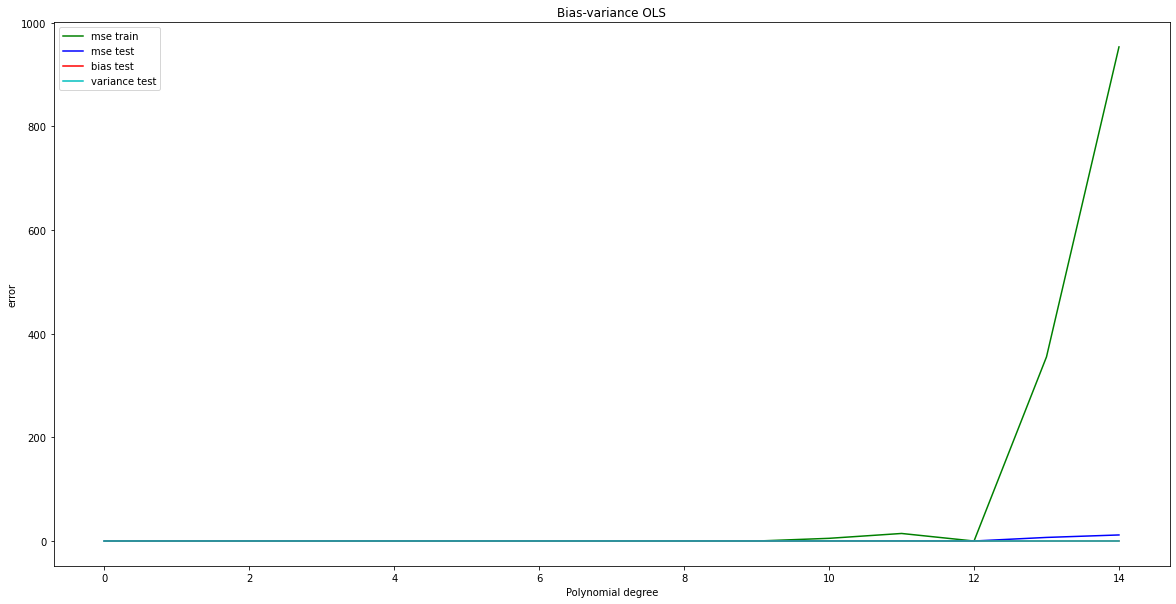

In [63]:
#creating data and neccesary storing arrays
np.random.seed(1337)
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
x =  np.ravel(x).reshape(np.size(x), 1)
y = np.ravel(y).reshape(np.size(y), 1)
z = FrankeFunction(x, y)
z = np.ravel(z)
deg = 15



errors_train = np.zeros(deg)
errors_test = np.zeros_like(errors_train)
biases = np.zeros_like(errors_train)
variances = np.zeros_like(errors_train)

x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.2, random_state=1337) 
for d in range(deg):
    
    error_train, error_test, bias_test, var_test = bootstrap(x_train, x_test, z_train, z_test, 100, d)
    
    errors_train[d] = error_train 
    errors_test[d] = error_test 
    biases[d] = bias_test
    variances[d] = var_test

plt.figure(figsize=[20, 10])
degrees = range(deg)
plt.title("Bias-variance OLS")
plt.plot(degrees,errors_train, c='g', label='mse train')
plt.plot(degrees, errors_test, c='b', label='mse test')
plt.plot(degrees, biases, c='r', label='bias test')
plt.plot(degrees, variances, c='c', label='variance test')
plt.xlabel('Polynomial degree')
plt.ylabel('error')
plt.legend()
plt.show()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


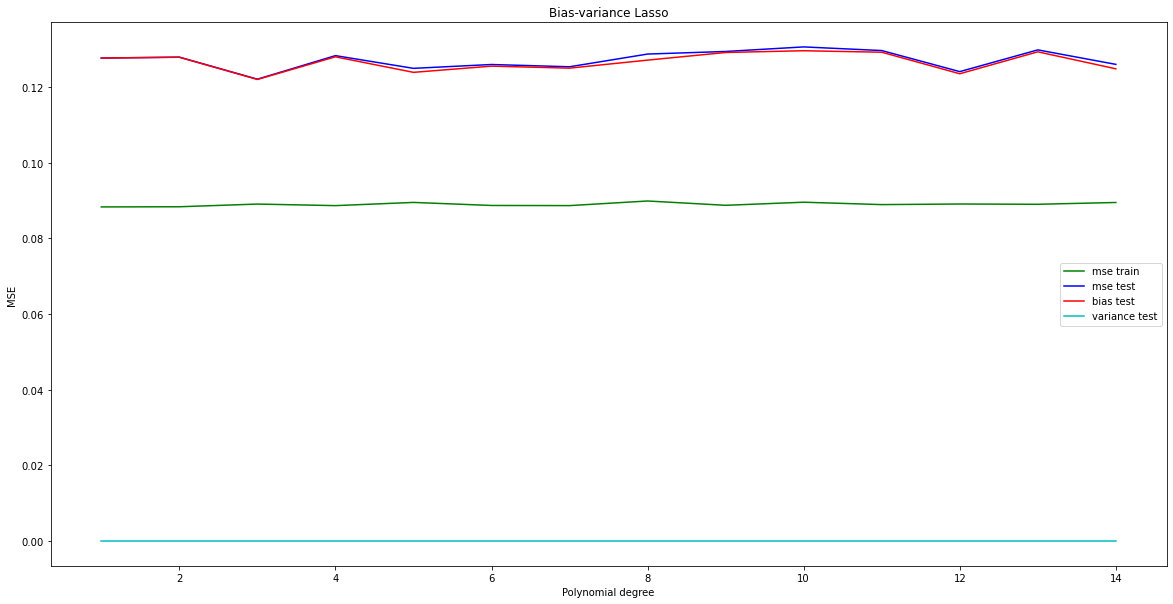

In [64]:
#Scikit Learn
from sklearn.linear_model import Lasso
np.random.seed(1337)



def Lasso_with_bootstrap(X_train, X_test, z_train, z_test, lambd, n):
    
    #alpha is our lambda (factor of the penalty)
    #1.0 means full penalty
    model = Lasso(alpha=lambd)
    
    #Fitting the model:
    model.fit(X_train, z_train)
    
    z_t = np.zeros((z_train.shape[0], n))
    z_pred = np.zeros((z_test.shape[0], n))
    
    for i in range(n):
        x_boot, z_boot = resample(x_train, z_train)
    
        model.fit(x_boot, z_boot)
        z_t[:,i] = model.predict(x_train)
        z_pred[:,i] = model.predict(x_test)
    mse_test, bias_test, var_test = mse_bootstrap(z_test.reshape(-1,1), z_pred)
    mse_train, bias_train, var_train = mse_bootstrap(z_train.reshape(-1,1), z_t)
    
    return mse_train, mse_test, bias_test, var_test


#Calling the function (copied from the bootstrap exercise)

x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
x = np.ravel(x).reshape(np.size(x), 1)
y = np.ravel(y).reshape(np.size(y), 1)
z = FrankeFunction(x, y)
z = np.ravel(z)
deg = 15


errors_train = np.zeros(deg)
errors_test = np.zeros_like(errors_train)
biases = np.zeros_like(errors_train)
variances = np.zeros_like(errors_train)

x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.2, random_state=1337) 

for d in range(deg):
    error_train, error_test, bias_test, var_test = Lasso_with_bootstrap(x_train, x_test, z_train, z_test, 100, d) 
    errors_train[d] = error_train 
    errors_test[d] = error_test 
    biases[d] = bias_test
    variances[d] = var_test

plt.figure(figsize=[20, 10])
plt.title("Bias-variance Lasso")
degrees = range(deg)
plt.plot(degrees,errors_train, c='g', label='mse train')
plt.plot(degrees, errors_test, c='b', label='mse test')
plt.plot(degrees, biases, c='r', label='bias test')
plt.plot(degrees, variances, c='c', label='variance test')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()
x = x.flatten()
y = y.flatten()
z = z.flatten()

#Cross-validation:

lambdas = np.logspace(-5, 5)



/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[            nan  0.00000000e+00 -1.38777878e-18 -9.25185854e-18
 -6.93889390e-18 -7.21644966e-18  6.47630098e-18  1.58603289e-17
  1.04083409e-18 -5.24271984e-18  6.93889390e-18  7.06505561e-18
 -2.19731640e-17 -2.77555756e-18 -8.72318091e-18]


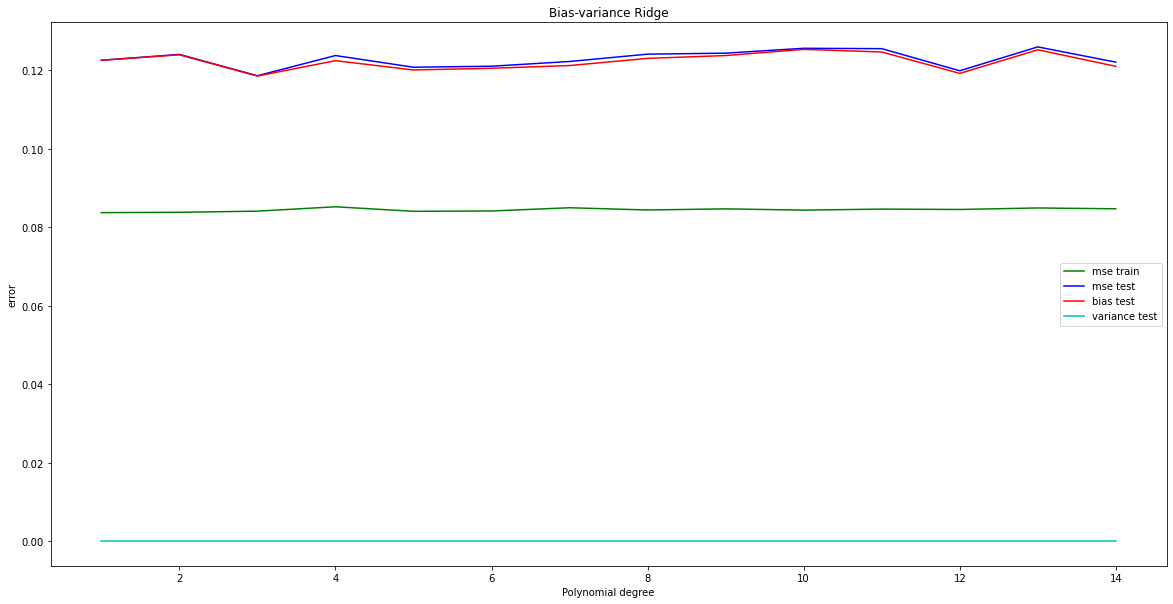

In [65]:
#Scikit Learn
from sklearn.linear_model import Ridge
np.random.seed(1337)



def Ridge_with_bootstrap(X_train, X_test, z_train, z_test, lambd, n):
    
    #alpha is our lambda (factor of the penalty)
    #1.0 means full penalty
    model = Ridge(alpha=lambd)
    
    #Fitting the model:
    model.fit(X_train, z_train)
    
    z_t = np.zeros((z_train.shape[0], n))
    z_pred = np.zeros((z_test.shape[0], n))
    
    for i in range(n):
        x_boot, z_boot = resample(x_train, z_train)
    
        model.fit(x_boot, z_boot)
        z_t[:,i] = model.predict(x_train)
        z_pred[:,i] = model.predict(x_test)
    mse_test, bias_test, var_test = mse_bootstrap(z_test.reshape(-1,1), z_pred)
    mse_train, bias_train, var_train = mse_bootstrap(z_train.reshape(-1,1), z_t)
    
    return mse_train, mse_test, bias_test, var_test


#Calling the function (copied from the bootstrap exercise)

x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
x = np.ravel(x).reshape(np.size(x), 1)
y = np.ravel(y).reshape(np.size(y), 1)
z = FrankeFunction(x, y)
z = np.ravel(z)
deg = 15


errors_train = np.zeros(deg)
errors_test = np.zeros_like(errors_train)
biases = np.zeros_like(errors_train)
variances = np.zeros_like(errors_train)

x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.2, random_state=1337) 

for d in range(deg):
    error_train, error_test, bias_test, var_test = Ridge_with_bootstrap(x_train, x_test, z_train, z_test, 100, d) 
    errors_train[d] = error_train 
    errors_test[d] = error_test 
    biases[d] = bias_test
    variances[d] = var_test

print(variances)
plt.figure(figsize=[20, 10])
plt.title("Bias-variance Ridge")
degrees = range(deg)
plt.plot(degrees,errors_train, c='g', label='mse train')
plt.plot(degrees, errors_test, c='b', label='mse test')
plt.plot(degrees, biases, c='r', label='bias test')
plt.plot(degrees, variances, c='c', label='variance test')
plt.xlabel('Polynomial degree')
plt.ylabel('error')
plt.legend()
plt.show()
x = x.flatten()
y = y.flatten()
z = z.flatten()

